In [26]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [27]:
# Define the path to the CSV file
file_path = './data/sales_train_evaluation.csv'

# Read the CSV file into a DataFrame
sales_df = pd.read_csv(file_path)


In [28]:
# Define the path to the CSV file
file_path = './data/calendar.csv'

# Read the CSV file into a DataFrame
calendar_df = pd.read_csv(file_path)


In [29]:
# Define the path to the CSV file
file_path = './data/sell_prices.csv'

# Read the CSV file into a DataFrame
prices_df = pd.read_csv(file_path)


In [30]:
sales_df.head(10)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
5,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,0,0,1,0,0,5,2,0
6,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
7,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,...,7,0,6,0,15,5,4,1,40,32
8,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,...,1,0,0,0,0,0,0,0,1,0
9,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,0,0,1,0,2,1,1,0,0,1


In [31]:
sales_df.shape

(30490, 1947)

In [32]:
# Reshaping the data from wide to long format, as to use days easier

sales_long = sales_df.melt(
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    var_name='day',
    value_name='sales'
)

In [33]:
# Set the date column as the index for easier lookup
calendar_df.set_index('date', inplace=True)


In [34]:
sales_long["cat_id"].value_counts()

cat_id
FOODS        27892170
HOUSEHOLD    20322270
HOBBIES      10966650
Name: count, dtype: int64

In [35]:
hobbies_sales_long = sales_long[sales_long['cat_id'] == 'HOBBIES']

In [36]:
hobbies_sales_long.shape

(10966650, 8)

In [37]:
ca_hobbies_sales_long = hobbies_sales_long[hobbies_sales_long['state_id'] == 'CA']

In [38]:
ca_hobbies_sales_long.shape

(4386660, 8)

In [39]:
## All SKU in Hobbie Department, within Primary Store in California
# About 1.1 M entries

alpha_ca_hobbies_sales_long = ca_hobbies_sales_long[ca_hobbies_sales_long['store_id'] == 'CA_1']

In [40]:
alpha_ca_hobbies_sales_long.shape

(1096665, 8)

In [41]:
alpha_ca_hobbies_sales_long.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [42]:
# Convert the 'day' column to an integer representing the day number
alpha_ca_hobbies_sales_long['day_num'] = alpha_ca_hobbies_sales_long['day'].str.extract('d_(\d+)').astype(int)

# Assume the first day is 2011-01-29, add the day numbers to get actual dates
start_date = datetime.datetime(2011, 1, 29)
alpha_ca_hobbies_sales_long['date'] = alpha_ca_hobbies_sales_long['day_num'].apply(lambda x: start_date + datetime.timedelta(days=x-1))

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\rafae\AppData\Local\Temp\ipykernel_5392\910560722.py:2: SyntaxWarning: invalid escape sequence '\d'
  alpha_ca_hobbies_sales_long['day_num'] = alpha_ca_hobbies_sales_long['day'].str.extract('d_(\d+)').astype(int)
C:\Users\rafae\AppData\Local\Temp\ipykernel_5392\910560722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_ca_hobbies_sales_long['day_num'] = alpha_ca_hobbies_sales_long['day'].str.extract('d_(\d+)').astype(int)
C:\Users\rafae\AppData\Local\Temp\ipykernel_5392\910560722.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [43]:
# Sort by id and date before creating rolling features
alpha_ca_hobbies_sales_long = alpha_ca_hobbies_sales_long.sort_values(by=['id', 'date'])

# Create a 7-day rolling average
alpha_ca_hobbies_sales_long['rolling_avg_7'] = alpha_ca_hobbies_sales_long.groupby('id')['sales'].transform(lambda x: x.rolling(7, min_periods=1).mean())
alpha_ca_hobbies_sales_long['rolling_avg_30'] = alpha_ca_hobbies_sales_long.groupby('id')['sales'].transform(lambda x: x.rolling(30, min_periods=1).mean())



In [44]:
alpha_ca_hobbies_sales_long.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales,day_num,date,rolling_avg_7,rolling_avg_30
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,1,2011-01-29,0.0,0.0
30490,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2,2011-01-30,0.0,0.0
60980,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0,3,2011-01-31,0.0,0.0
91470,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0,4,2011-02-01,0.0,0.0
121960,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0,5,2011-02-02,0.0,0.0


In [45]:
# Function to fetch calendar values for a given date
def fetch_calendar_features(row):
    

    # Some setup for later use
    weekday_mapping = {
        'Sunday': 1,
        'Monday': 2,
        'Tuesday': 3,
        'Wednesday': 4,
        'Thursday': 5,
        'Friday': 6,
        'Saturday': 7
    }

    # Here we are interacting with the sales_df (currently in the sales_long format)
    # Therefore, row is representing the sales_df
    # And calendar_info will be representing the calendar_df
    
    date = row['date']
    
    try:
        # Fetching specific date using `.loc[]` from calendar_df (which has date as index)
        calendar_info = calendar_df.loc[date]

        # Getting what we want
        # Weekday and Is_Weekend
        row['weekday'] = weekday_mapping[calendar_info['weekday']]  # Convert weekday name to numeric value
        row['is_weekend'] = 1 if calendar_info['weekday'] in ['Saturday', 'Sunday'] else 0

        # Month
        row['month'] = calendar_info['month']

        # Special Event/Holiday Indicator
        row['is_special'] = 1 if not pd.isna(calendar_info['event_name_1']) else 0

        # Checking for SNAP (Food Stamps) by State
        state = row["state_id"]
        row["snap"] = calendar_info[f"snap_" + state]

    except KeyError:
        # Handle missing dates by setting default values (e.g., 0 or None)
        row['weekday'] = None
        row['is_weekend'] = 0
        row['month'] = None
        row['is_special'] = 0
        row['snap'] = 0

    return row

In [46]:
#### RUN HERE on DAY 3 - 06.11

#alpha_ca_hobbies_sales_long = alpha_ca_hobbies_sales_long.apply(fetch_calendar_features, axis=1)

KeyboardInterrupt: 

_________________________________

In [19]:
sales_long.shape

(59181090, 8)

In [23]:
# Step 1: Split the DataFrame into chunks using numpy.array_split
num_chunks = 1000  # Set the number of chunks you want to split into
chunks = np.array_split(sales_long, num_chunks)


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [28]:
for i in range(0,100):
    chunks[i] = chunks[i].apply(fetch_calendar_features, axis=1)

KeyboardInterrupt: 

In [ ]:
#sales_long = sales_long.apply(fetch_calendar_features, axis=1)

______________________________________________

In [ ]:

# Step 2: Apply a function to each chunk
def my_function(df_chunk):
    # Your function logic here
    return df_chunk.apply(lambda x: ... , axis=1)  # Replace with your logic

processed_chunks = [my_function(chunk) for chunk in chunks]

# Step 3: Concatenate the chunks back together
result_df = pd.concat(processed_chunks, axis=0)

# Reset index if necessary
result_df.reset_index(drop=True, inplace=True)

# Now result_df contains the processed DataFrame


In [57]:
sales_long["day_num"].value_counts()

day_num
1       30490
1276    30490
1304    30490
1303    30490
1302    30490
        ...  
643     30490
642     30490
641     30490
640     30490
1941    30490
Name: count, Length: 1941, dtype: int64

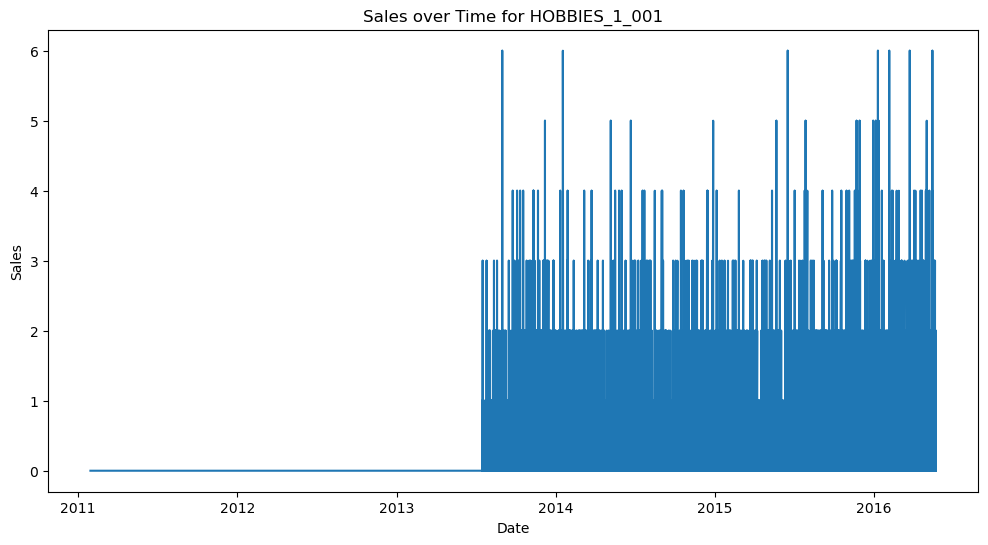

In [58]:
# Filter data for a specific item
item_sales = sales_long[sales_long['item_id'] == 'HOBBIES_1_001']

# Plot sales over time
plt.figure(figsize=(12, 6))
plt.plot(item_sales['date'], item_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales over Time for HOBBIES_1_001')
plt.show()

In [60]:
# Display the first few rows of the DataFrame
calendar_df.head(10)

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
date,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1


In [61]:
# Display the updated DataFrame
sales_long.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales,day_num,date,rolling_avg_7,rolling_avg_30
1612,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3,1,2011-01-29,3.0,3.0
32102,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0,2,2011-01-30,1.5,1.5
62592,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0,3,2011-01-31,1.0,1.0
93082,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1,4,2011-02-01,1.0,1.0
123572,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4,5,2011-02-02,1.6,1.6


In [62]:
# Print out the columns to verify the existence of the 'date' column
print("Sales Long Columns: ", sales_long.columns)
print("Calendar DF Columns: ", calendar_df.columns)


Sales Long Columns:  Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'day',
       'sales', 'day_num', 'date', 'rolling_avg_7', 'rolling_avg_30'],
      dtype='object')
Calendar DF Columns:  Index(['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI'],
      dtype='object')


In [63]:
# Ensure both DataFrames have 'date' as a datetime object
sales_long['date'] = pd.to_datetime(sales_long['date'])
#calendar_df['date'] = pd.to_datetime(calendar_df['date'])




In [64]:
# Also, set 'date' as the index in calendar_df if it was reset
#calendar_df.set_index('date', inplace=True)

In [67]:
# Convert date columns to datetime format
sales_long['date'] = pd.to_datetime(sales_long['date'])
calendar_df.index = pd.to_datetime(calendar_df.index)

# Reset the index of calendar_df to use in a merge
calendar_df_reset = calendar_df.reset_index()

# Merge sales_long with calendar_df on the 'date' column
sales_long = pd.merge(sales_long, calendar_df_reset, how='left', on='date')

# Create additional features after merge
# Weekday as numeric value (Sunday as 1)
weekday_mapping = {
    'Sunday': 1,
    'Monday': 2,
    'Tuesday': 3,
    'Wednesday': 4,
    'Thursday': 5,
    'Friday': 6,
    'Saturday': 7
}
sales_long['weekday'] = sales_long['weekday'].map(weekday_mapping)

# Create 'is_weekend' column
sales_long['is_weekend'] = sales_long['weekday'].apply(lambda x: 1 if x in [1, 7] else 0)

# Special event/holiday indicator
sales_long['is_special'] = sales_long['event_name_1'].notna().astype(int)

# Create 'snap' column based on state
sales_long['snap'] = sales_long.apply(lambda row: row[f"snap_{row['state_id']}"], axis=1)

# Drop unnecessary columns
sales_long.drop(columns=['event_name_1', 'snap_CA', 'snap_TX', 'snap_WI'], inplace=True)

# Display the updated DataFrame
print(sales_long.head())


MemoryError: Unable to allocate 452. MiB for an array with shape (59181090,) and data type int64

In [66]:
# Apply the function to each row in sales_long DataFrame
sales_long = sales_long.apply(fetch_calendar_features, axis=1)

# Display the updated DataFrame
print(sales_long.head())

MemoryError: 

In [ ]:
split_date = '2016-01-01'

# Split the data into training and testing sets
train_data = sales_long[sales_long['date'] < split_date]
test_data = sales_long[sales_long['date'] >= split_date]

# Check the size of your training and test sets
print(f"Training set size: {train_data.shape}")
print(f"Test set size: {test_data.shape}")